trainingFaces.shape[0]= 32256
trainingFaces.shape[1]= 2282
avgFace.shape = (32256,)
np.tile(avgFace,(trainingFaces.shape[1],1))(2282, 32256)
U.shape = (32256, 2282)


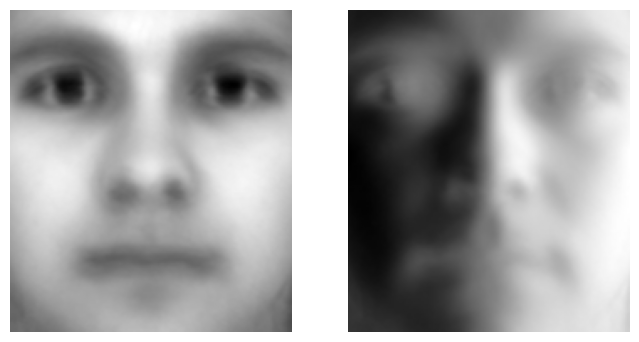

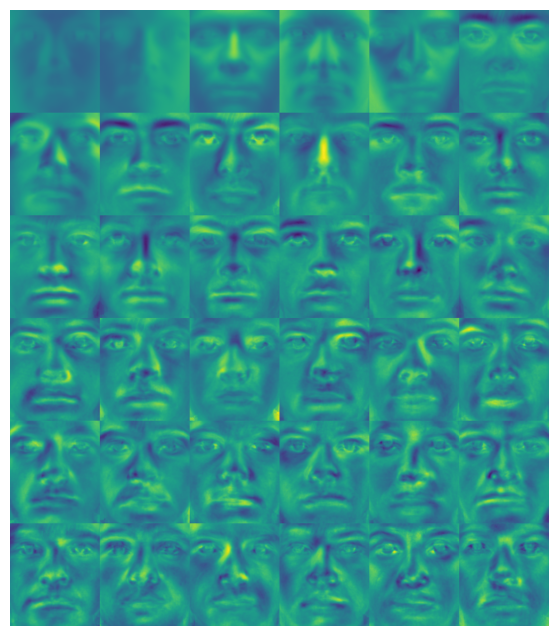

In [2]:


import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

mat_contents = scipy.io.loadmat(os.path.join('.','DATA','allFaces.mat'))
faces = mat_contents['faces']
m = int(np.squeeze(mat_contents['m']))
n = int(np.squeeze(mat_contents['n']))
nfaces = np.ndarray.flatten(mat_contents['nfaces'])


# We use the first 36 people for training data
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1) # size n*m by 1

print( "trainingFaces.shape[0]= " + str(trainingFaces.shape[0]) )
print( "trainingFaces.shape[1]= " + str(trainingFaces.shape[1]) )
print( "avgFace.shape = " + str(avgFace.shape) )
print( "np.tile(avgFace,(trainingFaces.shape[1],1))" + str(np.tile(avgFace,(trainingFaces.shape[1],1)).shape) )

# Compute eigenfaces on mean-subtracted training data
X = trainingFaces - np.tile(avgFace,(trainingFaces.shape[1],1)).T
U, S, VT = np.linalg.svd(X,full_matrices=0)

print( "U.shape = " + str(U.shape) )

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgFace,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')


ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:,1],(m,n)).T)
img_u1.set_cmap('gray')
plt.axis('off')

plt.show()


allUs = np.zeros((n*6,m*6))
for j in range(6):
    for k in range(6):
        allUs[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(U[:,j*6+k],(m,n)).T

plt.axis('off')
plt.imshow(allUs)



In the below code:


The RAM spikes because the original line builds a huge dense matrix with $U_r U_r^T$.

- $U_r$ has shape $(mn) \times r$. For faces, $mn$ is the number of pixels (e.g., $112 \times 92 = 10304$), so $U_r U_r^T$ becomes a $(mn) \times (mn)$ matrix.
- That’s roughly $10304^2 \approx 1.06 \times 10^8$ floats. At 8 bytes per float64, that’s about 0.85 GB just for that one matrix, plus overhead and temporary buffers during the matmul.
- NumPy will allocate additional temporary arrays during the chained multiply, so peak memory can easily exceed a few GB and lock up VS Code.

The fix avoids forming $U_r U_r^T$ by doing $U_r (U_r^T \, \text{testFaceMS})$, which only uses vectors/matrices of size $(mn)\times r$ and $r\times 1$, so memory stays small.

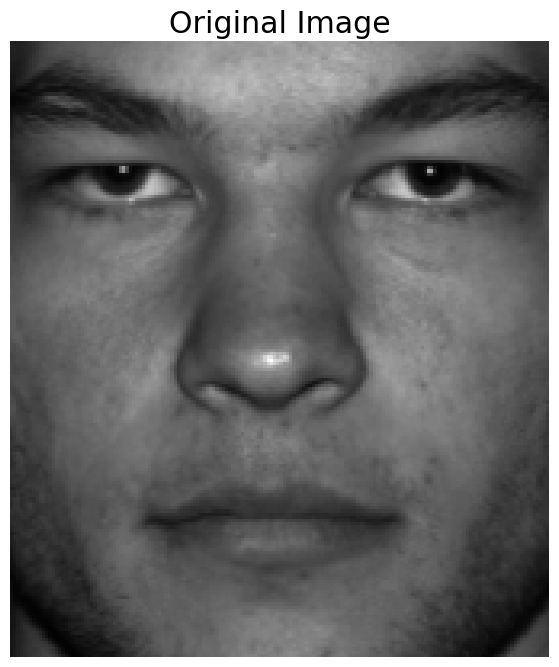

coeffs.shape = (25,)
approxI.shape = (32256,)


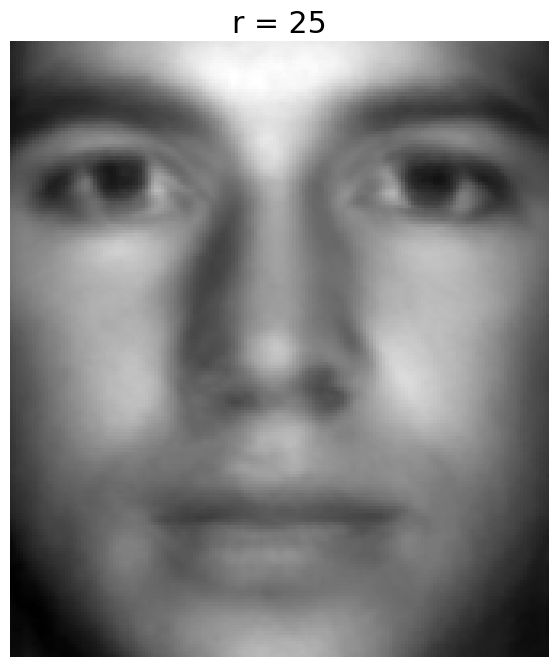

coeffs.shape = (50,)
approxI.shape = (32256,)


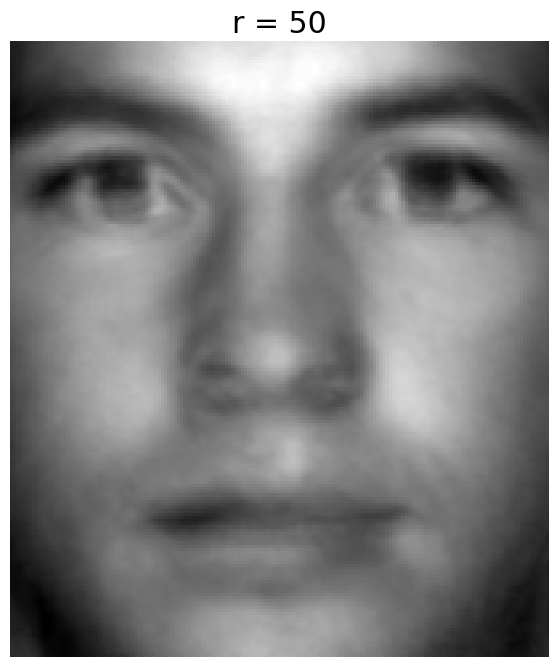

coeffs.shape = (100,)
approxI.shape = (32256,)


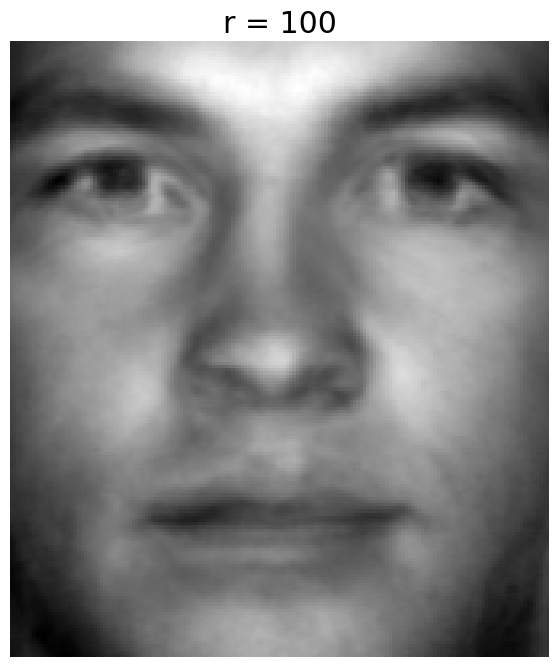

coeffs.shape = (200,)
approxI.shape = (32256,)


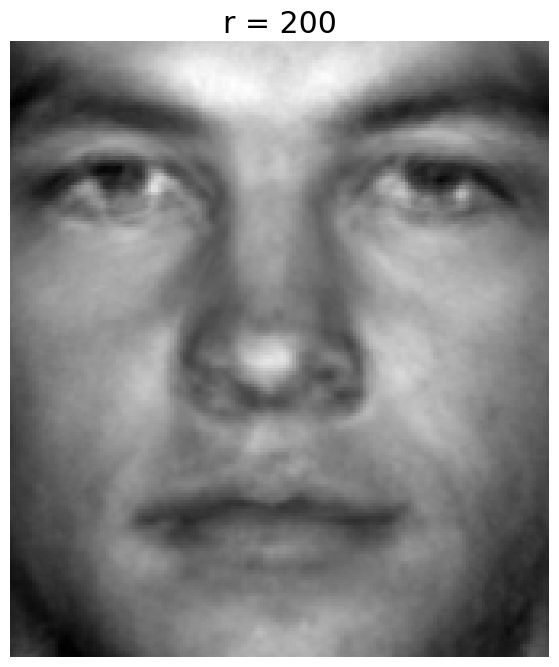

coeffs.shape = (400,)
approxI.shape = (32256,)


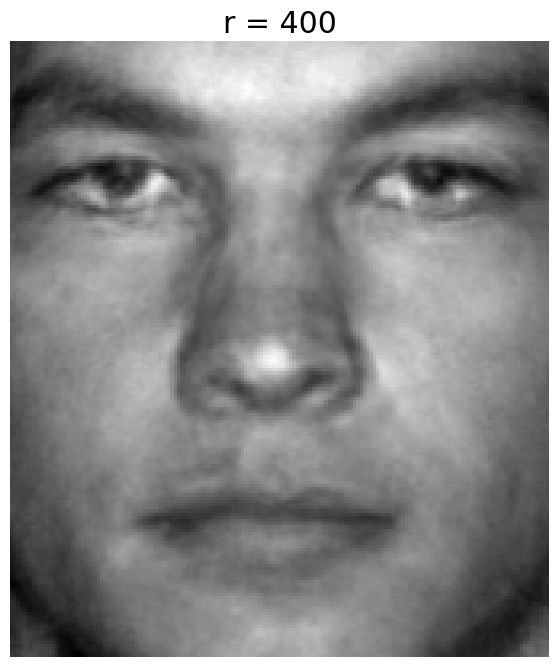

coeffs.shape = (800,)
approxI.shape = (32256,)


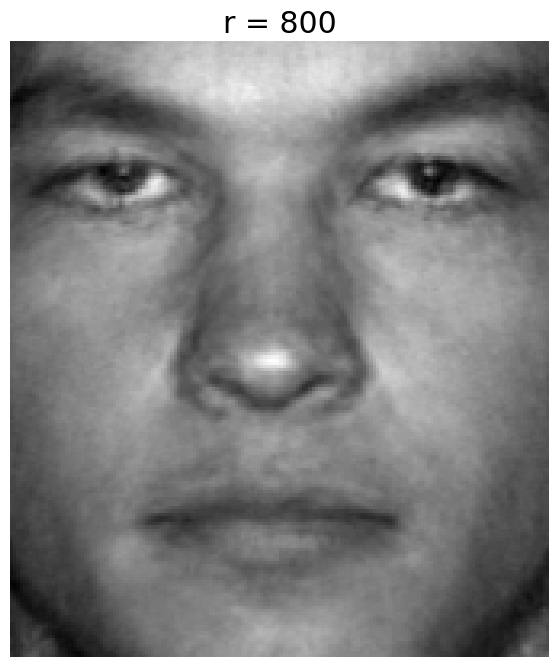

coeffs.shape = (1200,)
approxI.shape = (32256,)


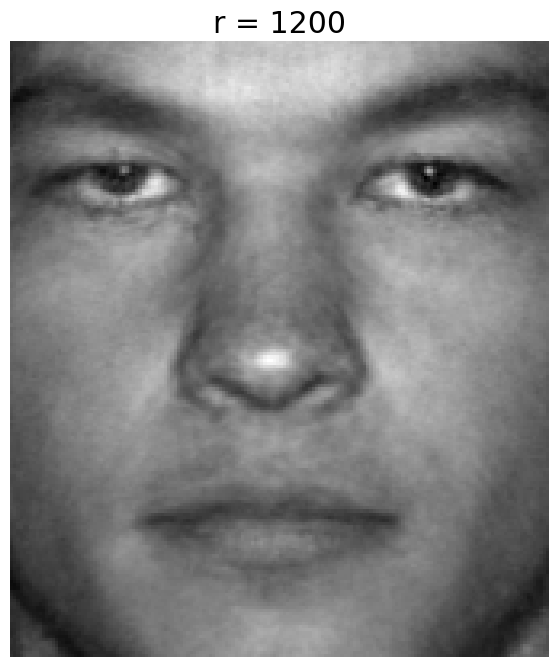

coeffs.shape = (1600,)
approxI.shape = (32256,)


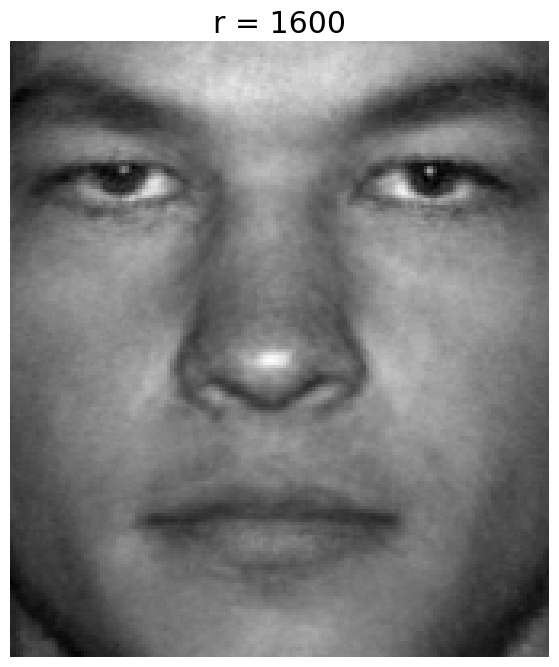

In [ ]:

## Now show eigenface reconstruction of image that was omitted from test set

testFace = faces[:,np.sum(nfaces[:36])] # First face of person 37
plt.imshow(np.reshape(testFace,(m,n)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

testFaceMS = testFace - avgFace
r_list = [25, 50, 100, 200, 400, 800, 1200, 1600]

for r in r_list:
    # Original (kept for reference):
    # reconFace = avgFace + U[:,:r]  @ U[:,:r].T @ testFaceMS
    U_r = U[:, :r]
    # Project onto the r-dimensional subspace without forming the full U_r @ U_r.T

    
    coeffs = U_r.T @ testFaceMS
    print( "coeffs.shape = " + str(coeffs.shape) )
    approxI = U_r @ coeffs
    print( "approxI.shape = " + str(approxI.shape) )
    reconFace = avgFace + approxI
    img = plt.imshow(np.reshape(reconFace,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()



P1.shape = (32256, 62)
P2.shape = (32256, 64)
(2, 62)
(2, 64)


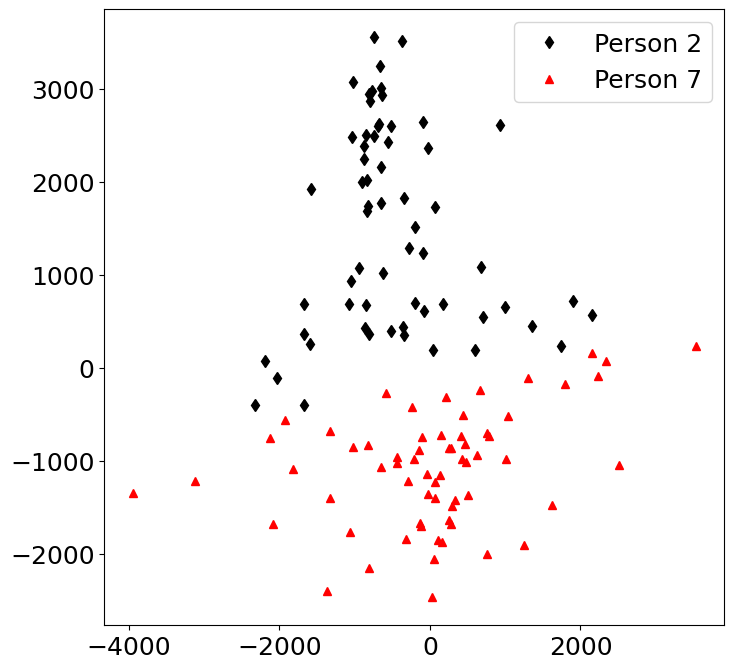

In [5]:

## Project person 2 and 7 onto PC5 and PC6

P1num = 2 # Person number 2
P2num = 7 # Person number 7

P1 = faces[:,np.sum(nfaces[:(P1num-1)]):np.sum(nfaces[:P1num])]
P2 = faces[:,np.sum(nfaces[:(P2num-1)]):np.sum(nfaces[:P2num])]

P1 = P1 - np.tile(avgFace,(P1.shape[1],1)).T
P2 = P2 - np.tile(avgFace,(P2.shape[1],1)).T


print( "P1.shape = " + str(P1.shape) )
print( "P2.shape = " + str(P2.shape) )
PCAmodes = [5, 6] # Project onto PCA modes 5 and 6
PCACoordsP1 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P1
PCACoordsP2 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P2

print( PCACoordsP1.shape )
print( PCACoordsP2.shape )  
plt.plot(PCACoordsP1[0,:],PCACoordsP1[1,:],'d',color='k',label='Person 2')
plt.plot(PCACoordsP2[0,:],PCACoordsP2[1,:],'^',color='r',label='Person 7')

plt.legend()
plt.show()

